# Import Libaries

In [50]:
import os
import shutil
import folium
import imageio
import rioxarray 
import webbrowser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from glob import glob  
from osgeo import gdal
from pyproj import Transformer
from IPython.display import Image
from natsort import natsorted, ns
from mpl_toolkits.mplot3d import Axes3D

import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import rasterio  
from rasterio.plot import show
from rasterio.windows import Window

%matplotlib inline

# Generete directory proper management

In [51]:
main_dir = ['3D Image',"search address data", 'DSM', 'DTM']

for i in main_dir:
    if not os.path.exists(i):
        os.makedirs(i)

# Search all ".tif" files in working dir and sort arrage the files

In [52]:
def search_tif(path):

    tif_files =[]
    
    # using glob library to get all the file with .tif
    files = glob(path,recursive = True) 
    for file in files: 
        tif_files.append(file)
        
    # ascending order sort files with number in the file
    tif_files = natsorted(tif_files, alg=ns.IGNORECASE)     
    return tif_files

In [53]:
DSM_vla_tif = search_tif('.\\DSM\\**\\*.tif')
DTM_vla_tif = search_tif('.\\DTM\\**\\*.tif')

# Geo Location  of Single Address
---
* "User_Agent" is an http request header that is sent with each request. Nominatim requires this value to be set to your application name. The goal is to be able to limit the number of requests per application. "geocode" method, for resolving a location from a string, and may define a reverse method, which resolves a pair of coordinates to an address.
* Folium makes it easy to visualize map data it is interactive 'map' Classes for drawing maps. can save in image or interactive html. "marker" set market type.
* "pyproj.Transformer" has the capabilities of performing 2D, 3D, and 4D (time) transformations. Transform Geo to Bel Geo cordinates
---
* Recieve X and Y value EPSG:31370 to compare with .tif file to find the what file does the location of the x and y is

## Function to create Map Location using GeoPy

In [54]:
# to get the longtitude and latitude of the address entered & plot address on a map

def lat_long(address):
    
    # GeoPy to get longtitude and latitude 
    geolocator = Nominatim(user_agent="Address_GeoLocator")
    location = geolocator.geocode(address)
    house_lat_long = [location.latitude, location.longitude]
    return house_lat_long

def house_locate(func):
    
    # to plot address 

    house_locate = folium.Map(location=func,zoom_start=18)
    folium.Marker(location=func,
                  popup=list(func), 
                  icon=folium.Icon(color='green', icon='location-arrow', prefix='fa')  # Customize Icon
                 ).add_to(house_locate)
    #house_locate.save(address+".html")
    return house_locate

def EPSG_Bel(lon, lat):
    
    # transform to Belgium 'EPSG:31370' coordinate
    transformer = Transformer.from_crs("EPSG:4326", 
                                       crs_to = 'EPSG:31370',
                                       always_xy=True) #output coordinates using the traditional GIS order
    x, y = transformer.transform(lon, lat)
    
    return x,y

In [55]:
# search_address = "Bosuil 130 2100 Antwerpen"
# search_address = "Koningin Astridplein 27 2018 Antwerpen"
search_address = "Bolivarplaats 20, 2000 Antwerpen"
house_locate(lat_long(search_address))

In [56]:
lat,lon = lat_long(search_address)
x, y = EPSG_Bel(lon, lat)

print((x, y) , (lat, lon))

(151310.3780146367, 210432.52079995256) (51.2038583, 4.387506485817034)


# Getting Longitute and Latitude form the ".tif" file
___
* GIS raster dataset every pixels of a dataset is contained within a spatial bounding box

In [57]:
# create all bounding box from tifs
def bounding_box(tifs):

    bounds = []

    for i in tifs:
        src = rasterio.open(i)    # open the source file
        bounds.append(src.bounds) # grab the bounding box corordinates

    return  bounds


# Locate tif that contains the location and geting the location
def check_tif(x,y):

    for i,b_box in enumerate(bounding_box_cordinates,1): # number the bounding box

        if (x >= b_box[0] and x <= b_box[2]) & (y >= b_box[1] and y <= b_box[3]):  # condition to filter the corordinates

            if i in range(1,10): # add '0' for signle digit number to get correct files
                i = "0" + str(i)
            else:
                i = str(i)
            
            dsm_path = f'./DSM/DHMVIIDSMRAS1m_k{i}/GeoTIFF/DHMVIIDSMRAS1m_k{i}.tif'
            dtm_path = f'./DTM/DHMVIIDTMRAS1m_k{i}/GeoTIFF/DHMVIIDTMRAS1m_k{i}.tif'

            print('DSM File :', f'DHMVIIDSMRAS1m_k{i}.tif')
            print('DTM File :', f'DHMVIIDTMRAS1m_k{i}.tif')
            
    return dsm_path, dtm_path

In [58]:
bounding_box_cordinates = bounding_box(DSM_vla_tif)

tif_path = check_tif(x,y)

print()

dsm_location = tif_path[0]
print(dsm_location)

print()

dtm_location = tif_path[1]
print(dtm_location)

DSM File : DHMVIIDSMRAS1m_k15.tif
DTM File : DHMVIIDTMRAS1m_k15.tif

./DSM/DHMVIIDSMRAS1m_k15/GeoTIFF/DHMVIIDSMRAS1m_k15.tif

./DTM/DHMVIIDTMRAS1m_k15/GeoTIFF/DHMVIIDTMRAS1m_k15.tif


# Function to clip the house model

In [73]:
def clip_tif(path,window_size=30):
 
    xds = rioxarray.open_rasterio(path,masked=True)
    
    data_file = path[2:5].lower()
    
    # set window size
    n = window_size  # meters

    # create coordinates and geometries
    coor1,coor2 = [(x-n),(y+n)],[(x+n),(y+n)]

    coor3,coor4 = [(x+n),(y-n)] ,[(x-n),(y-n)]

    geometries = [ {'type': 'Polygon', 'coordinates': [[coor1,coor2, coor3,coor4,coor1 ]]}]

    # clip the image as per the geometries size
    clipped = xds.rio.clip(geometries)
    
    # save clip for Canopy Height Model
    clip = clipped.rio.to_raster(f"{search_address}_clipped_{data_file}.tif",tiled=True, dtype="int32")
    
    shutil.move(f"{search_address}_clipped_{data_file}.tif", f"./search address data/{search_address}_clipped_{data_file}.tif")


    return clipped.plot();

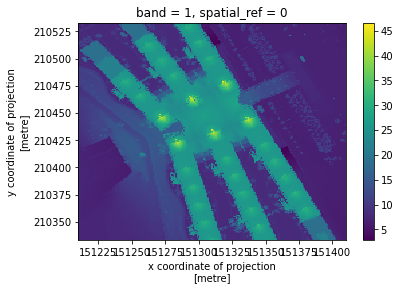

In [78]:
clip_tif(dsm_location,100);

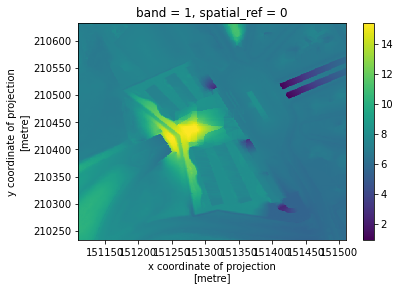

In [79]:
clip_tif(dtm_location,200);

# Function for Canopy Height Model

In [68]:
def chm_tif():
    
    # open the digital terrain model 
    with rasterio.open(f'search address data/{search_address}_clipped_dtm.tif') as src:
        lidar_dtm_im = src.read(1, masked=True)
        dtm_meta = src.profile
        src.close()
        
    # open the digital surface model 
    with rasterio.open(f'search address data/{search_address}_clipped_dsm.tif') as src:
        lidar_dsm_im = src.read(1, masked=True)
        dsm_meta = src.profile
        src.close()
    
    # calculate canopy height model
    lidar_chm = lidar_dsm_im - lidar_dtm_im
    
    # save chm clipped 
    with rasterio.open(f'search address data/{search_address}_clipped_chm.tif', 'w', **dsm_meta) as ff:
        ff.write(lidar_chm,1)
        ff.close()
        
    chm_tif = f'search address data/{search_address}_clipped_chm.tif'
    
    return chm_tif

In [69]:
ds = gdal.Open(chm_tif())
data = ds.ReadAsArray()
data = data.astype(np.float32)
ds = None   # Close gdal.open

In [75]:
fig = go.Figure(data=[go.Surface(z=data)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor="limegreen", project_z=True))
fig.update_layout(title=search_address)
fig.show()
fig.write_image(f"./{main_dir[0]}/{search_address}.png")

# ds = None   # Close gdal.open

In [16]:
# to view actual house on google map
url = 'https://www.google.com.my/maps/place/'+str(lat)+','+str(lon)
webbrowser.open(url)

True